# <font color='blue'>Regression Team Project</font>
**Fast Campus Data Science School 7th**

## Overview
- Team: Team B-5 committer (김선웅, 이영인, 장승우)
- Subject: New York City Taxi Trip Duration
- Dataset: 2016 NYC Cab trip record data (by TLC)
- Objective: Building a model that predicts the duration of each trip in New York City.
- Evaluation: RMSLE 

## Data fields
- id - 각 운행별 고유 id
- vendor_id - 운행별 각 택시 회사의 id
- pickup_datetime - 승차 날짜/시각 (미터기 기록 시작)
- dropoff_datetime - 하차 날짜/시각 (미터기 기록 종료)
- passenger_count - 승객 수
- pickup_longitude - 승차 위도
- pickup_latitude - 승차 경도
- dropoff_longitude - 하차 위도
- dropoff_latitude - 하차 경도
- store_and_fwd_flag - 운행 기록 서비 전송 전 차량 메모리 저장 여부 (Y: 저장/전송, N: 미저장/전송)
- trip_duration - 운행 소요 시간 (초)

## Contents

### 1. 데이터 탐색 및 전처리
- Train/Test Data 탐색
- 변수 기초 전처리

### 2. 변수 분석
- 변수 시각화
- 변수간 상관관계 파악
- 변수 중요도/영향 파악

### 3. Modeling
- 1차 modeling
    - outlier 제거
- 2차 modeling

### 4. 결과 진단
- cross validation
- 정규화 하이퍼 모수 최적화

### 5. Kaggle submission

### 6. Lesson

## 1. 데이터 탐색 및 전처리

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import datetime as dt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms 

from patsy import dmatrix, dmatrices

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False

import platform
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)

import warnings
warnings.filterwarnings("ignore")

/Users/sunwoongkim/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### 1-1. train & test data 기본 탐색

In [2]:
train = pd.read_csv("../dataset/train.csv", parse_dates=["pickup_datetime", "dropoff_datetime"])
print("Shape of Train Data: ", train.shape)

Shape of Train Data:  (1458644, 11)


In [3]:
test = pd.read_csv("../dataset/test.csv", parse_dates=["pickup_datetime"])
print("Shape of Test Data: ", test.shape)

Shape of Test Data:  (625134, 9)


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null datetime64[ns]
dropoff_datetime      1458644 non-null datetime64[ns]
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: datetime64[ns](2), float64(4), int64(3), object(2)
memory usage: 122.4+ MB


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 625134 entries, 0 to 625133
Data columns (total 9 columns):
id                    625134 non-null object
vendor_id             625134 non-null int64
pickup_datetime       625134 non-null datetime64[ns]
passenger_count       625134 non-null int64
pickup_longitude      625134 non-null float64
pickup_latitude       625134 non-null float64
dropoff_longitude     625134 non-null float64
dropoff_latitude      625134 non-null float64
store_and_fwd_flag    625134 non-null object
dtypes: datetime64[ns](1), float64(4), int64(2), object(2)
memory usage: 42.9+ MB


In [6]:
for col in train.columns:
    if col != "id":
        print("The number of unique values of {col}: {num}".format(col=col, num=len(train[col].unique())))

The number of unique values of vendor_id: 2
The number of unique values of pickup_datetime: 1380222
The number of unique values of dropoff_datetime: 1380377
The number of unique values of passenger_count: 10
The number of unique values of pickup_longitude: 23047
The number of unique values of pickup_latitude: 45245
The number of unique values of dropoff_longitude: 33821
The number of unique values of dropoff_latitude: 62519
The number of unique values of store_and_fwd_flag: 2
The number of unique values of trip_duration: 7417


In [7]:
print("Features only in training data:", set(train.columns) - set(test.columns))

Features only in training data: {'dropoff_datetime', 'trip_duration'}


In [8]:
train.tail()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,778
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,655
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,764
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,373
1458643,id1209952,1,2016-04-05 14:44:25,2016-04-05 14:47:43,1,-73.979538,40.781750,-73.972809,40.790585,N,198


In [9]:
train.describe().round(3)

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000
mean,1.535,1.665,-73.973,40.751,-73.973,40.752,959.492
std,0.499,1.314,0.071,0.033,0.071,0.036,5237.432
min,1.000,0.000,-121.933,34.360,-121.933,32.181,1.000
25%,1.000,1.000,-73.992,40.737,-73.991,40.736,397.000
50%,2.000,1.000,-73.982,40.754,-73.980,40.755,662.000
75%,2.000,2.000,-73.967,40.768,-73.963,40.770,1075.000
max,2.000,9.000,-61.336,51.881,-61.336,43.921,3526282.000


### [데이터 기초 탐색 결과]

1. vendor는 두 곳
2. 승객 수는 0명부터 9명
3. 승차 위치와 하차 위치는 크게 다르지 않아 보임
4. store and fwd flag의 데이터는 N/Y로 표현되어 binarize 필요해 보임
5. trip duration의 경우 최댓값이 평균에 비해 아주 크며, 최솟값과 최댓값간의 차이 또한 매우 큼

### 1-2. 데이터 전처리

### datetime

- datetime parsing
    - month
    - weekday
    - hour


- working day 카테고리 생성

In [10]:
train["pickup_month"] = train["pickup_datetime"].dt.month
train["pickup_weekday"] = train["pickup_datetime"].dt.weekday
train["pickup_hour"] = train["pickup_datetime"].dt.hour

In [11]:
working_day = [0, 1, 2, 3, 4] # Mon-Fri
train["working_day"] = train["pickup_weekday"].isin(working_day).astype(int)

### store_and_fwd_flag
- binarize를 통해 문자열 labeling

In [12]:
train["store_and_fwd_flag"] = 1 * (train.store_and_fwd_flag.values == 'Y')

### 좌표 데이터 (pickup latitude/longitude, dropoff latitude/longitude)
- distance (haversine distance) 계산
- bearing (direction) 계산

In [13]:
lat1, lng1, lat2, lng2 = (train['pickup_latitude'].values, train['pickup_longitude'].values, 
                          train['dropoff_latitude'].values, train['dropoff_longitude'].values)

In [14]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

In [15]:
def bearing_array(lat1, lng1, lat2, lng2):
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return (np.degrees(np.arctan2(y, x)) + 360) % 360 # from -180/180 to 0/360

In [16]:
train = train.assign(distance = haversine_array(lat1, lng1, lat2, lng2))
train = train.assign(bearing = bearing_array(lat1, lng1, lat2, lng2))

### 전처리 후 추가된 변수

- 시간
    - pickup_month
    - pickup_weekday
    - pickup_hour
    - working_day (categorical variable)


- 위치
    - distance
    - bearing

In [17]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 17 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null datetime64[ns]
dropoff_datetime      1458644 non-null datetime64[ns]
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null int64
trip_duration         1458644 non-null int64
pickup_month          1458644 non-null int64
pickup_weekday        1458644 non-null int64
pickup_hour           1458644 non-null int64
working_day           1458644 non-null int64
distance              1458644 non-null float64
bearing               1458644 non-null float64
dtypes: datetime64[ns](2), float64(6), int64(8), object(1)
memory usage: 189.2+ MB


In [18]:
print(train.shape)
print()
for col in train.columns:
    if col != "id":
        print("The number of unique values of {col}: {num}".format(col=col, num=len(train[col].unique())))

(1458644, 17)

The number of unique values of vendor_id: 2
The number of unique values of pickup_datetime: 1380222
The number of unique values of dropoff_datetime: 1380377
The number of unique values of passenger_count: 10
The number of unique values of pickup_longitude: 23047
The number of unique values of pickup_latitude: 45245
The number of unique values of dropoff_longitude: 33821
The number of unique values of dropoff_latitude: 62519
The number of unique values of store_and_fwd_flag: 2
The number of unique values of trip_duration: 7417
The number of unique values of pickup_month: 6
The number of unique values of pickup_weekday: 7
The number of unique values of pickup_hour: 24
The number of unique values of working_day: 2
The number of unique values of distance: 1452285
The number of unique values of bearing: 1452020


In [19]:
train.tail()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_month,pickup_weekday,pickup_hour,working_day,distance,bearing
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,0,778,4,4,13,1,1.225080,240.940662
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,0,655,1,6,7,0,6.049836,25.342196
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,0,764,4,4,6,1,7.824606,209.211508
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,0,373,1,1,15,1,1.092564,35.033294
1458643,id1209952,1,2016-04-05 14:44:25,2016-04-05 14:47:43,1,-73.979538,40.781750,-73.972809,40.790585,0,198,4,1,14,1,1.134042,29.969486


In [20]:
train.describe().round(3)

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_month,pickup_weekday,pickup_hour,working_day,distance,bearing
count,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000
mean,1.535,1.665,-73.973,40.751,-73.973,40.752,0.006,959.492,3.517,3.050,13.606,0.715,3.441,153.406
std,0.499,1.314,0.071,0.033,0.071,0.036,0.074,5237.432,1.681,1.954,6.400,0.452,4.297,104.220
min,1.000,0.000,-121.933,34.360,-121.933,32.181,0.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000
25%,1.000,1.000,-73.992,40.737,-73.991,40.736,0.000,397.000,2.000,1.000,9.000,0.000,1.232,44.305
50%,2.000,1.000,-73.982,40.754,-73.980,40.755,0.000,662.000,4.000,3.000,14.000,1.000,2.094,168.517
75%,2.000,2.000,-73.967,40.768,-73.963,40.770,0.000,1075.000,5.000,5.000,19.000,1.000,3.875,224.361
max,2.000,9.000,-61.336,51.881,-61.336,43.921,1.000,3526282.000,6.000,6.000,23.000,1.000,1240.909,359.993


### 2. 변수 탐색/분석

### 2-1  변수 시각화

### trip duration의 분포 (입력 오류로 보이는 데이터 4건 확인 및 제거: 500시간을 초과)

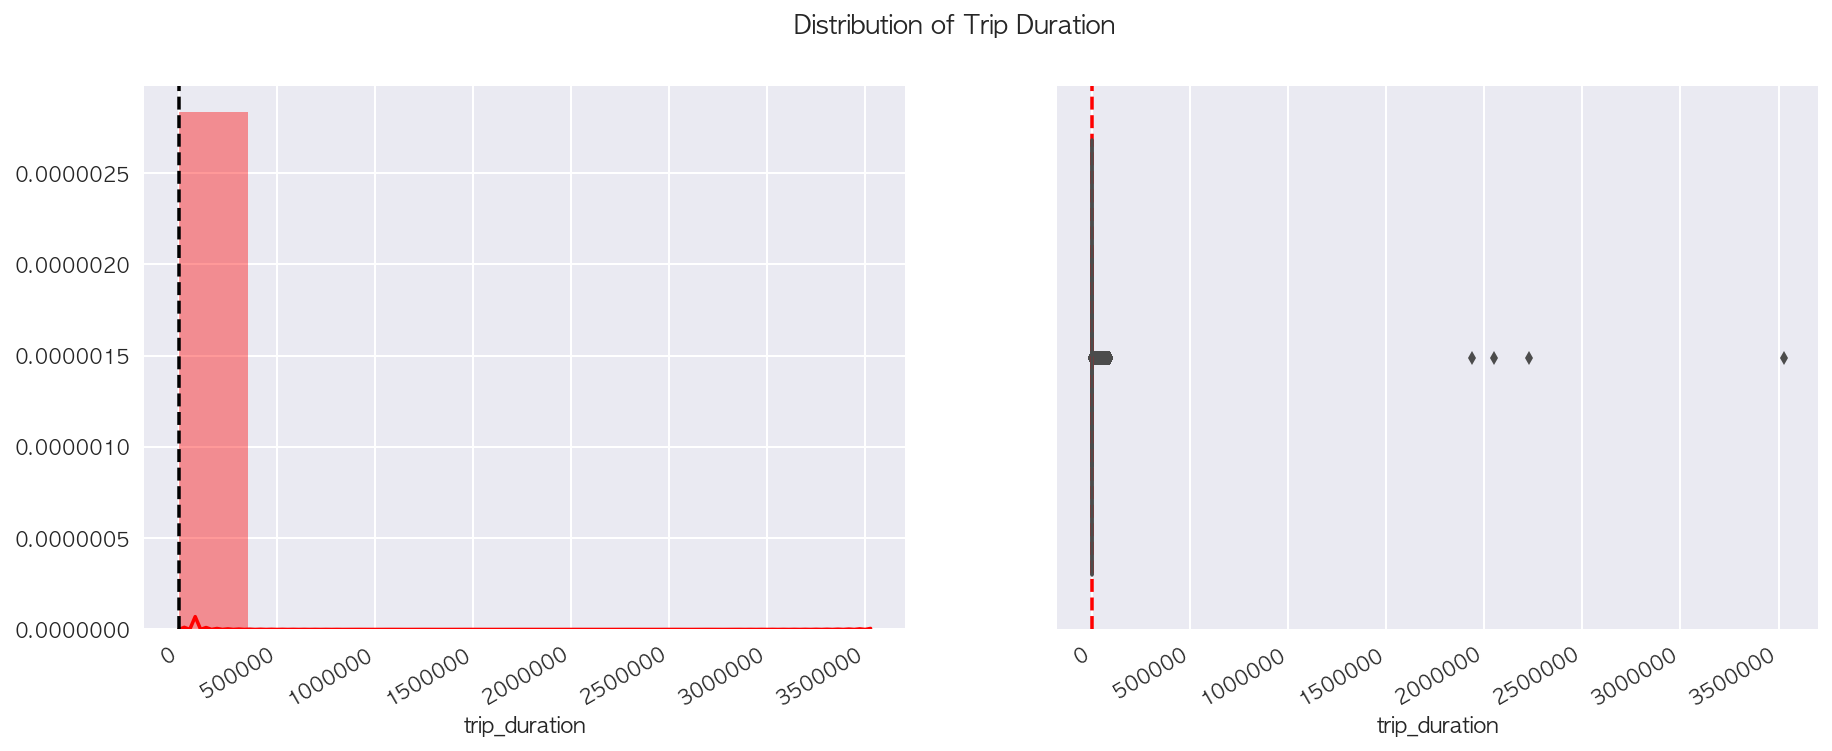

In [21]:
plt.figure(figsize=(15, 5))
plt.suptitle("Distribution of Trip Duration", fontsize=13)

plt.subplot(121)
sns.distplot(train["trip_duration"], color="r",bins=10)
plt.axvline(train["trip_duration"].median(), linestyle='dashed', color="k")
plt.xticks(rotation=30, ha='right')

plt.subplot(122)
sns.boxplot(train["trip_duration"])
plt.axvline(train["trip_duration"].median(), linestyle='dashed', color="r")
plt.xticks(rotation=30, ha='right')

plt.show()

In [22]:
train[train["trip_duration"] > 1500000]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_month,pickup_weekday,pickup_hour,working_day,distance,bearing
355003,id1864733,1,2016-01-05 00:19:42,2016-01-27 11:08:38,1,-73.789650,40.643559,-73.956810,40.773087,0,1939736,1,1,0,1,20.148664,315.683698
680594,id0369307,1,2016-02-13 22:38:00,2016-03-08 15:57:38,2,-73.921677,40.735252,-73.984749,40.759979,0,2049578,2,5,22,0,5.982487,297.381354
924150,id1325766,1,2016-01-05 06:14:15,2016-01-31 01:01:07,1,-73.983788,40.742325,-73.985489,40.727676,0,2227612,1,1,6,1,1.635128,185.030076
978383,id0053347,1,2016-02-13 22:46:52,2016-03-25 18:18:14,1,-73.783905,40.648632,-73.978271,40.750202,0,3526282,2,5,22,0,19.900661,304.641003


In [23]:
train = train[train["trip_duration"] < 1500000]

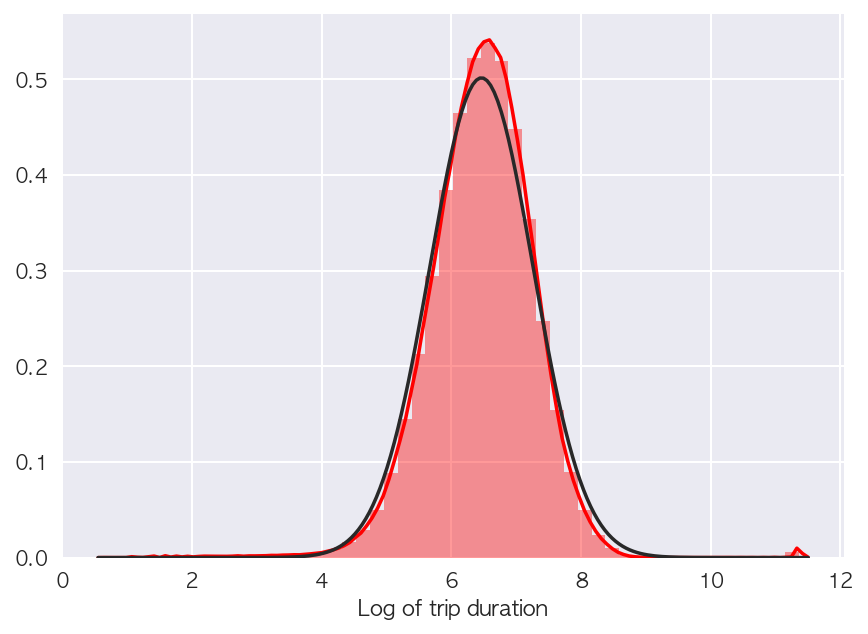

In [24]:
plt.figure(figsize=(7, 5))
sns.distplot(np.log1p(train["trip_duration"]), fit=sp.stats.norm, color="r")
plt.xlabel("Log of trip duration")
plt.show()

### 종속변수/독립변수 분리 후 pairplot
- 실수 변수
- 카테고리 변수

In [25]:
X_cols = [col for col in train.columns if col != "trip_duration"]
train_X0 = train[X_cols]
train_y = train[["trip_duration"]]

In [26]:
col_real = ["passenger_count", "distance", "bearing", "pickup_longitude", 
            "pickup_latitude", "dropoff_longitude", "dropoff_latitude"]

col_cats = [col for col in train.columns if col not in col_real]
for col in ["pickup_datetime", "dropoff_datetime", "id"]:
    col_cats.remove(col)
col_cats_nontime = ["vendor_id", "store_and_fwd_flag", "working_day"]

### trip_duration ~ 실수 변수  pairplot
- trip_duration
- passenger_count
- distance
- bearing

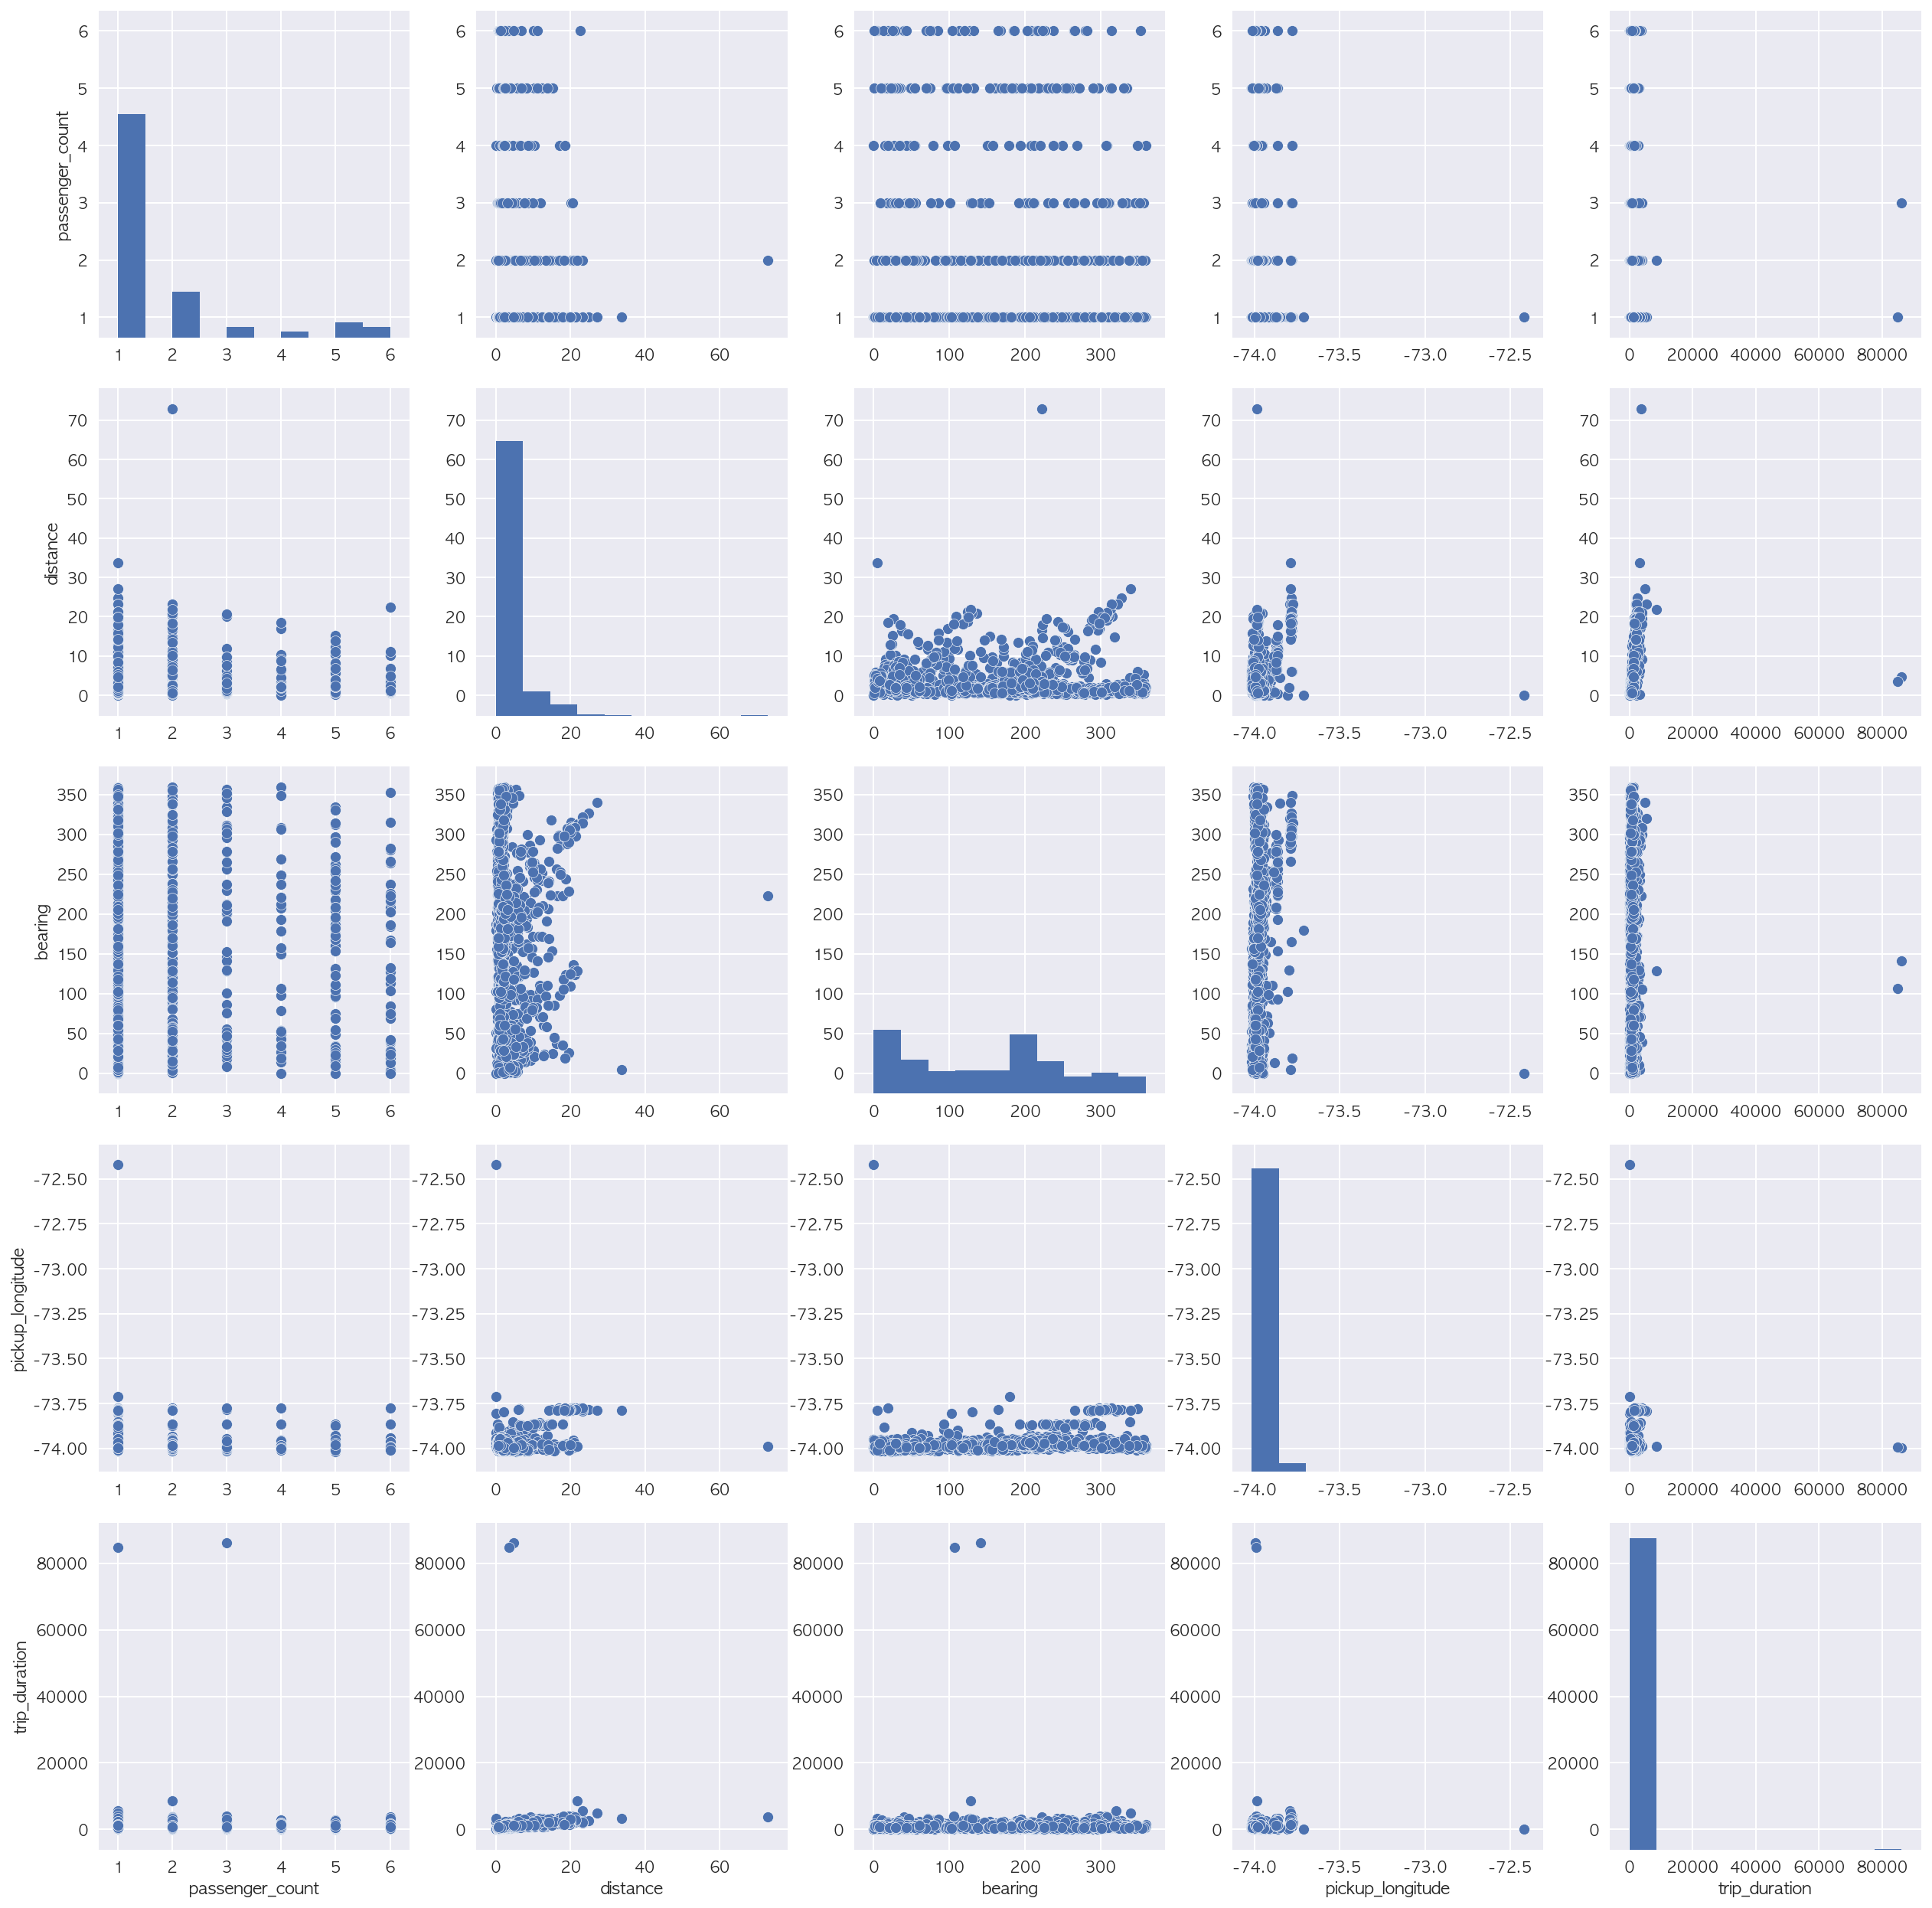

In [27]:
sns.pairplot(pd.concat([train_X0[col_real[:4]], train_y], axis=1)[::1000], size=3.5)
plt.show()

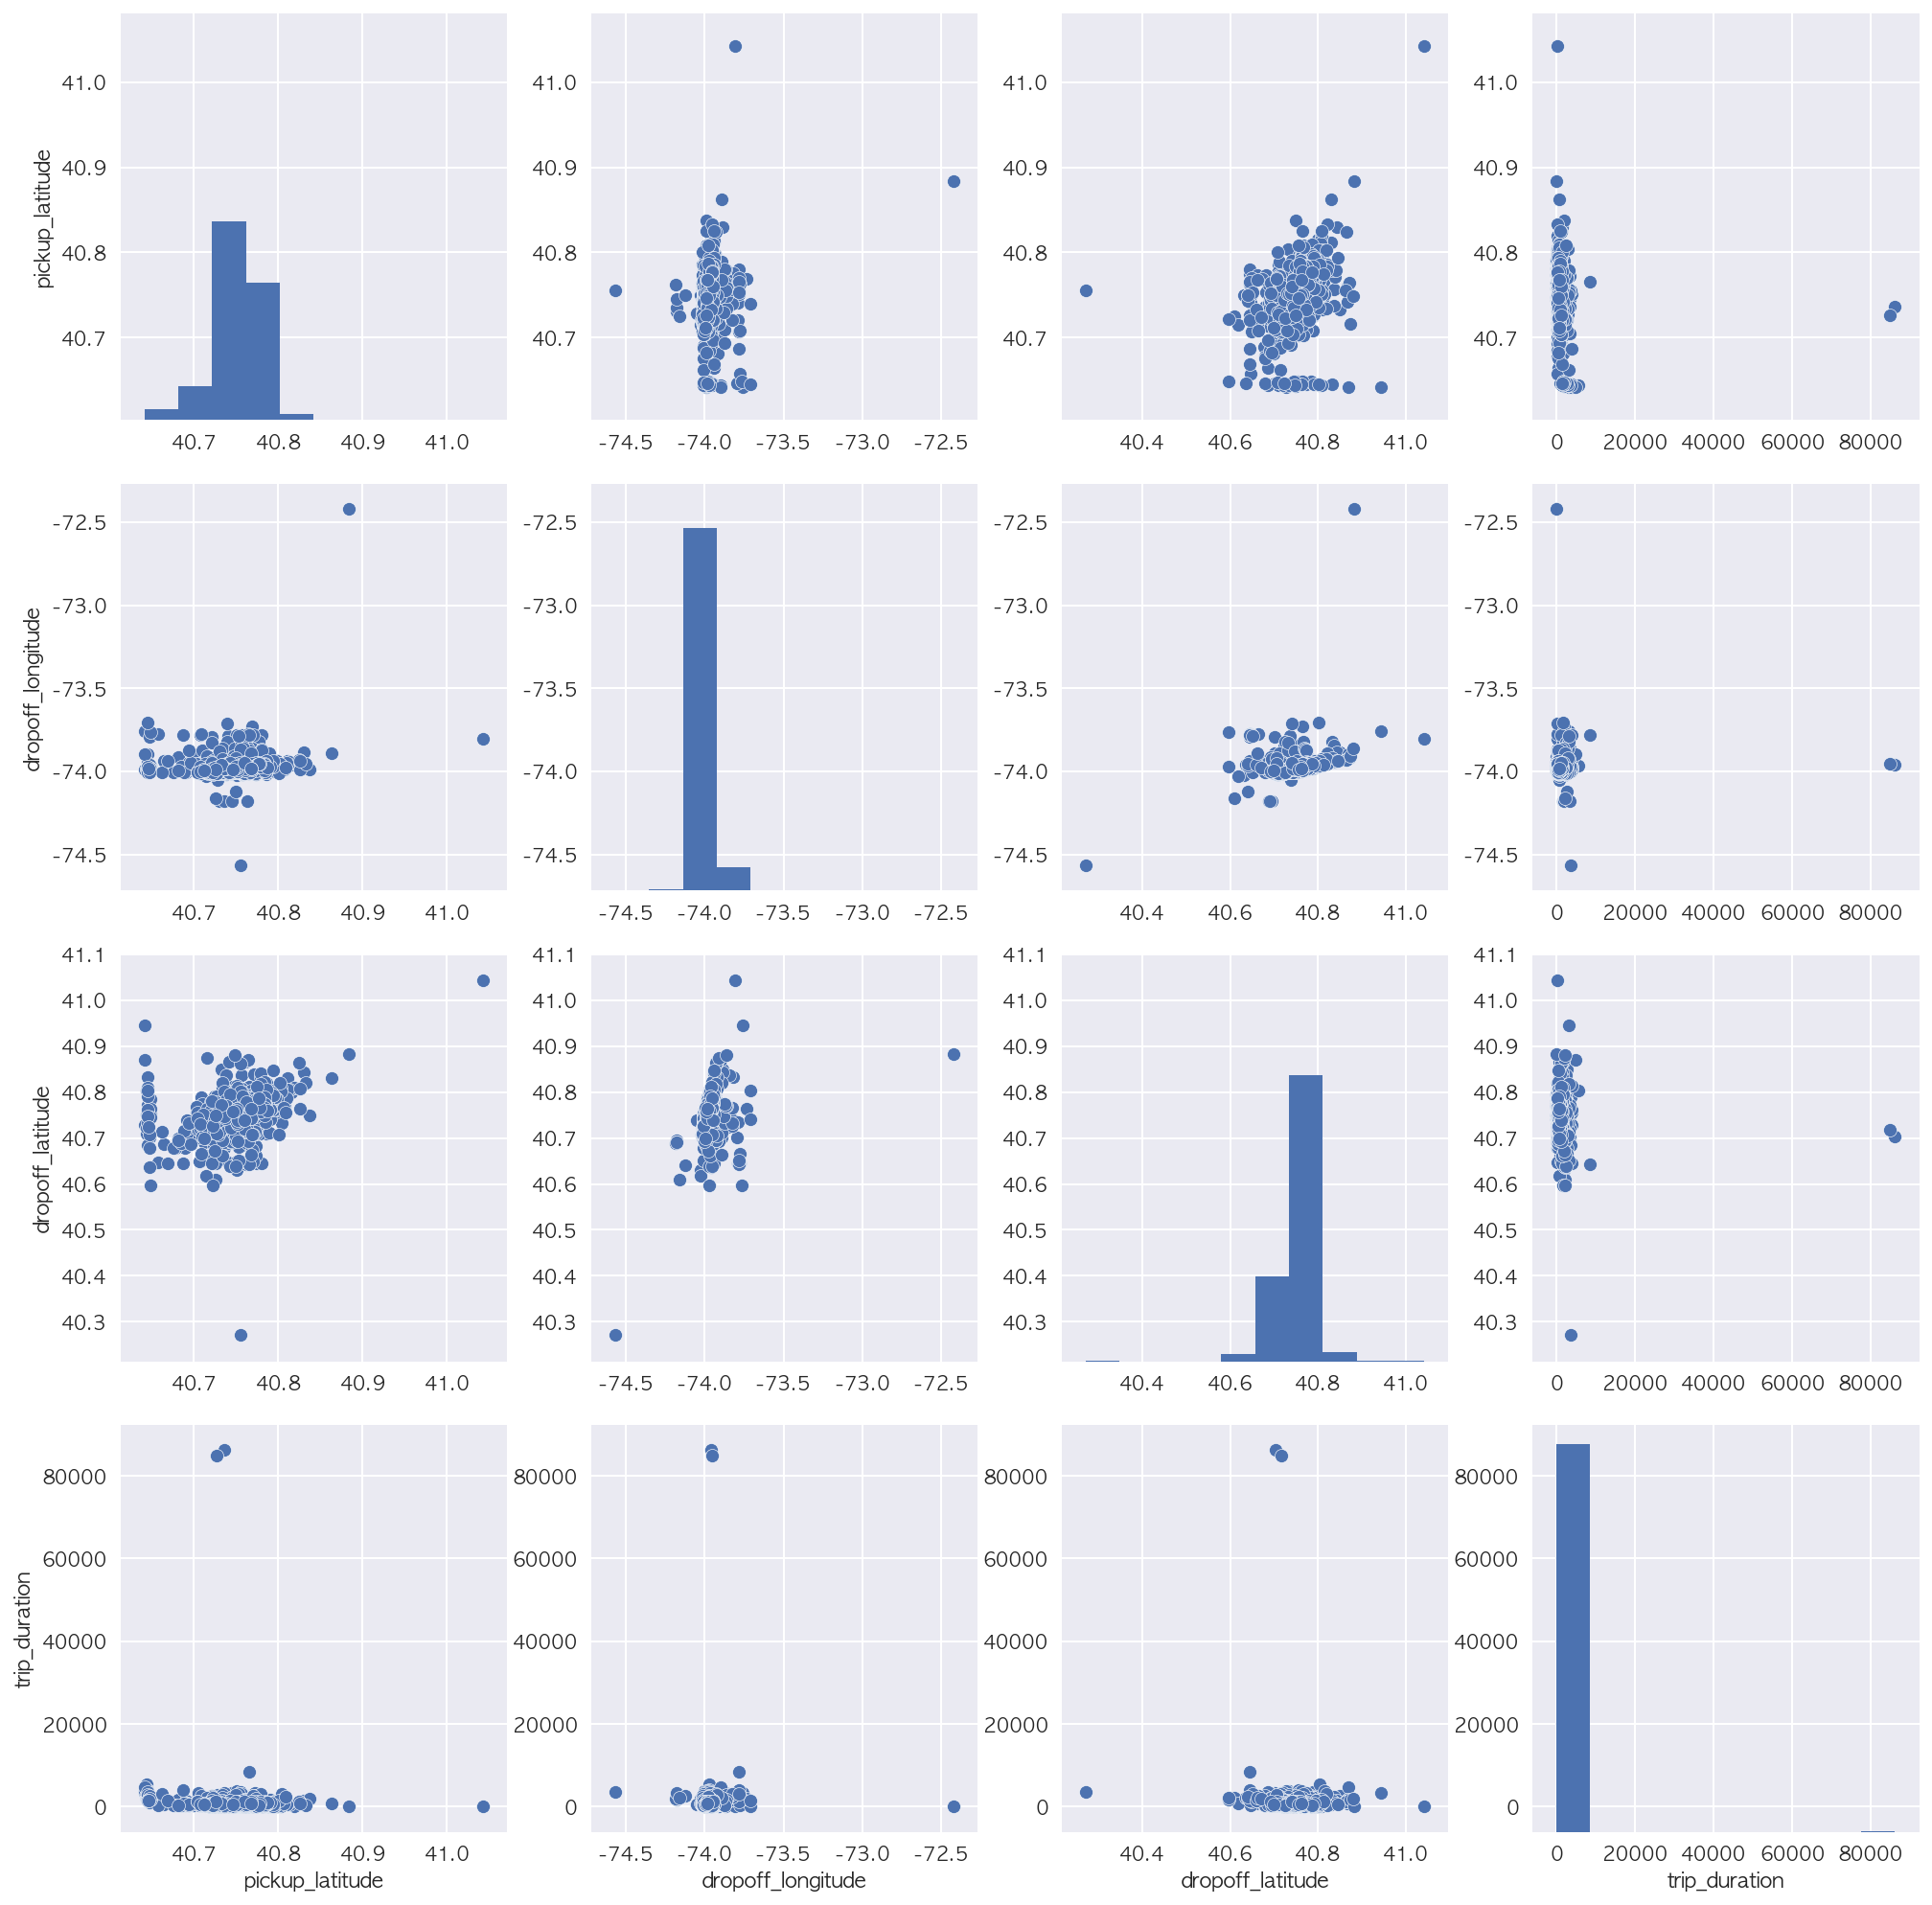

In [28]:
sns.pairplot(pd.concat([train_X0[col_real[4:]], train_y], axis=1)[::1000], size=3.5)
plt.show()

### 카테고리 변수 boxplot

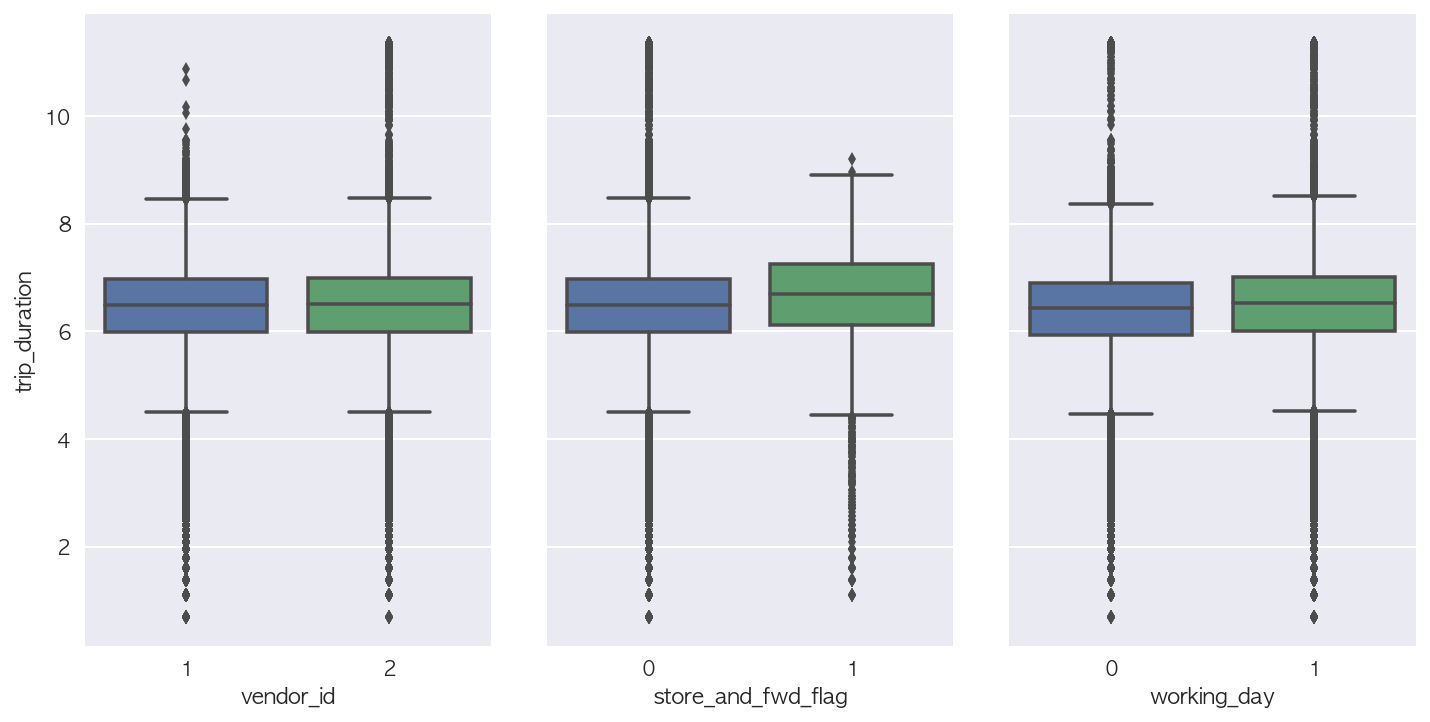

In [29]:
f, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 5), sharey=True)
f.tight_layout()

sns.boxplot(x="vendor_id", y=np.log1p(train["trip_duration"]), data=train, ax=axes[0])
sns.boxplot(x="store_and_fwd_flag", y=np.log1p(train["trip_duration"]), data=train, ax=axes[1])
sns.boxplot(x="working_day", y=np.log1p(train["trip_duration"]), data=train, ax=axes[2])

axes[1].set_ylabel('')
axes[2].set_ylabel('')

plt.show()

- pairplot과 boxplot을 통해 확인할 수 있는 이상치: 80000 이상의 trip_duration

In [30]:
print("The Number of trips almost 24 hours:", train[train["trip_duration"] > 80000].shape[0])

The Number of trips almost 24 hours: 1895


### 위치 변수의 분포 확인 (특정 지점에 집중된 분포)

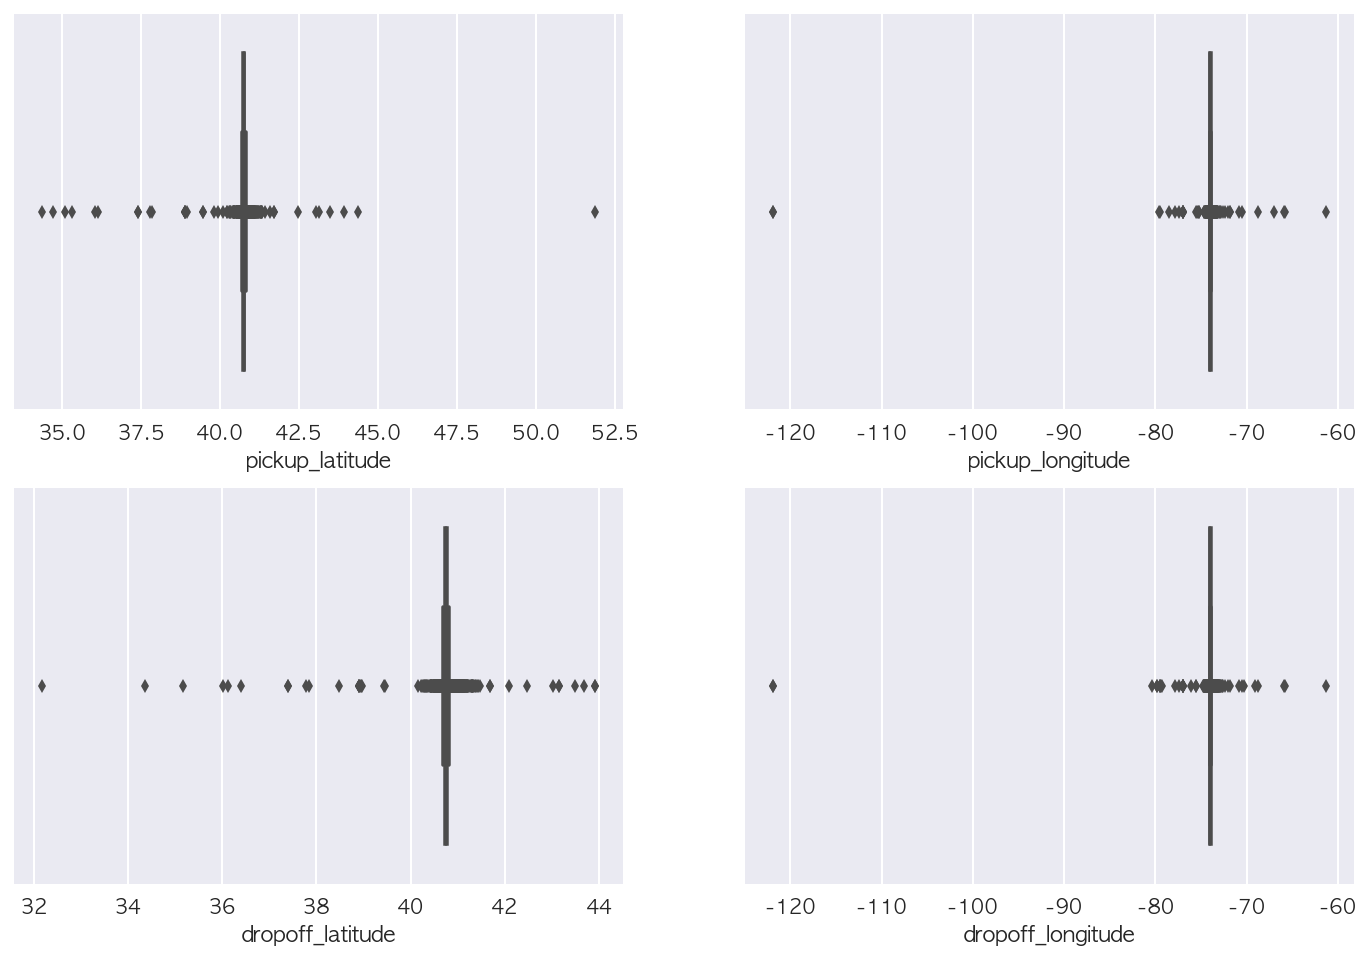

In [31]:
plt.figure(figsize=(12, 8))

plt.subplot(221); sns.boxplot(train["pickup_latitude"])
plt.subplot(222); sns.boxplot(train["pickup_longitude"])
plt.subplot(223); sns.boxplot(train["dropoff_latitude"])
plt.subplot(224); sns.boxplot(train["dropoff_longitude"])

plt.show()

- **NYC 경계 (google maps를 통해 확인):**
    - latitude: 약 40.5 ~ 40.90
    - longitude: 약 -74.24 ~ -73.70

### 동떨어진 위경도 좌표 확인 (입력오류로 보이는 데이터: 미 서부, 캐나다, 대서양)

In [32]:
import folium

weird_p = train.loc[(train["pickup_latitude"]>45) | (train["pickup_longitude"]<-100)]
weird_d = train.loc[(train["dropoff_latitude"]<36) | (train["dropoff_longitude"]<-120)]
map_weird = folium.Map(location=[38.720716, -100.721951], tiles='OpenStreetMap', zoom_start=3)

for idx, row in weird_p.iterrows(): 
    folium.CircleMarker([row["pickup_latitude"], row["pickup_longitude"]], 
                        radius=3, color="red", fill=True, fill_color="red").add_to(map_weird)

for idx, row in weird_d.iterrows(): 
    folium.CircleMarker([row["dropoff_latitude"], row["dropoff_longitude"]], 
                        radius=3, color="blue", fill=True, fill_color="blue").add_to(map_weird)
map_weird

### NYC 내의 승하차 분포 파악

<img src="https://github.com/novdov/dss7b5-nyctaxi/blob/master/img/nyc_map_plot.png?raw=true" width="800">

### 시간 변수 탐색

### 시간/요일별 trip duration 변화 (9시~19시 중 trip duration이 높음, 주중에 trip duration이 더 높음)

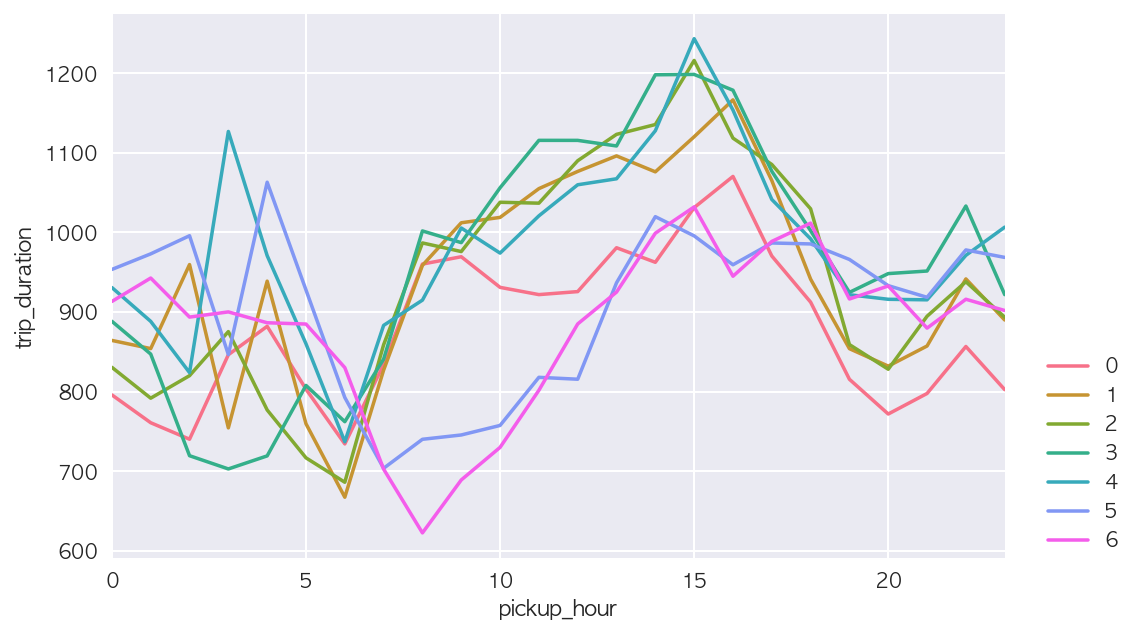

In [33]:
summary_hour_duration = pd.DataFrame(train.groupby(["pickup_weekday", "pickup_hour"])["trip_duration"].mean())
summary_hour_duration.reset_index(inplace = True)
summary_hour_duration["unit"]=1

plt.figure(figsize=(8, 5))
sns.tsplot(data=summary_hour_duration, time="pickup_hour", 
           unit = "unit", condition="pickup_weekday", value="trip_duration")
plt.legend(loc=(1.04,0))
plt.show()

### 월별 trip duration 변화 (6월이 될수록 trip duration이 점점 높아짐)

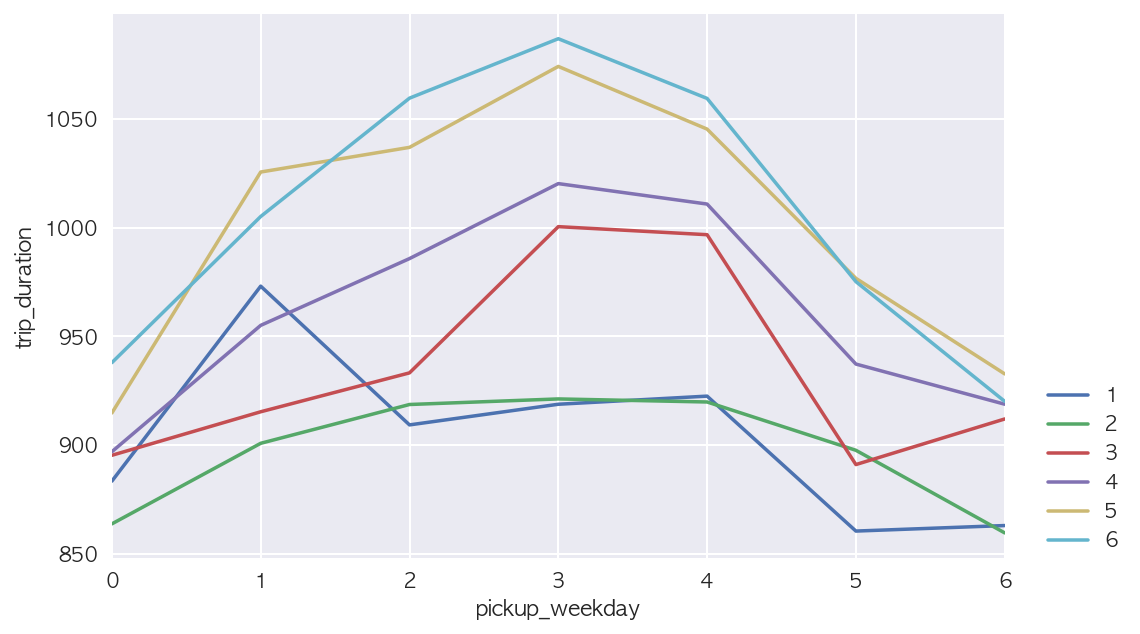

In [34]:
summary_weekday_duration = pd.DataFrame(train.groupby(["pickup_month", "pickup_weekday"])["trip_duration"].mean())
summary_weekday_duration.reset_index(inplace = True)
summary_weekday_duration["unit"]=1

plt.figure(figsize=(8, 5))
sns.tsplot(data=summary_weekday_duration, time="pickup_weekday", 
           unit = "unit", condition="pickup_month", value="trip_duration")
plt.legend(loc=(1.04,0))
plt.show()

### 주중/주말 시간별 trip duration 변화 (주중에 더 trip duration이 높음)

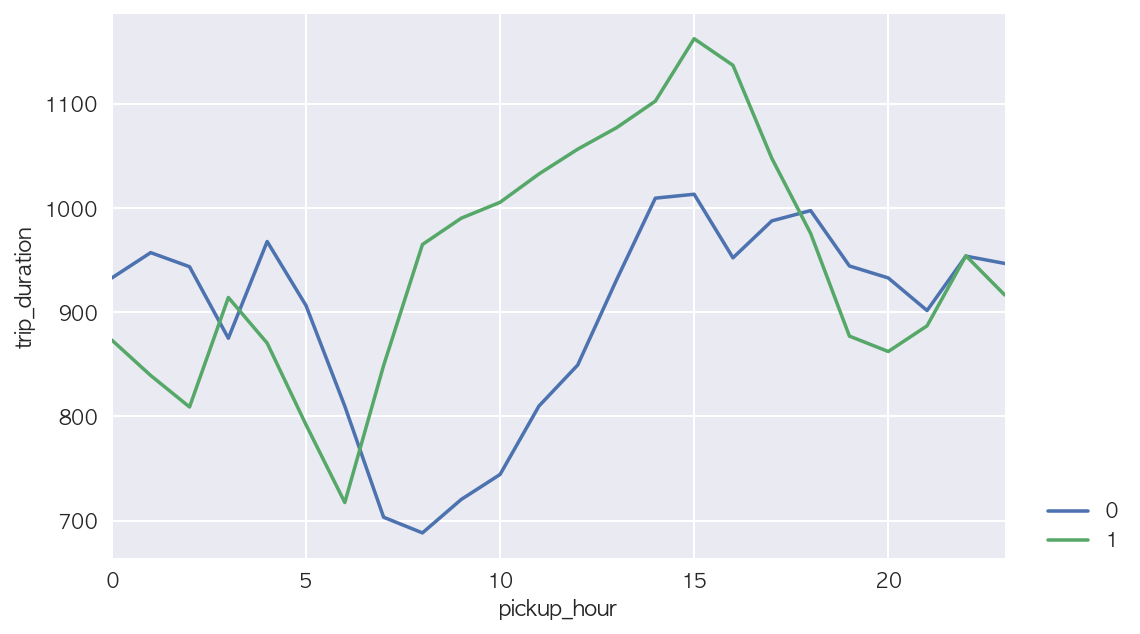

In [35]:
summary_wd_duration = pd.DataFrame(train.groupby(["working_day", "pickup_hour"])["trip_duration"].mean())
summary_wd_duration.reset_index(inplace = True)
summary_wd_duration["unit"]=1

plt.figure(figsize=(8, 5))
sns.tsplot(data=summary_wd_duration, time="pickup_hour", 
           unit = "unit", condition="working_day", value="trip_duration")
plt.legend(loc=(1.04,0))
plt.show()

### 2-2. 변수간 상관관계 파악

### 변수간 상관관계 heatmap (위치 변수간 높은 상관관계)

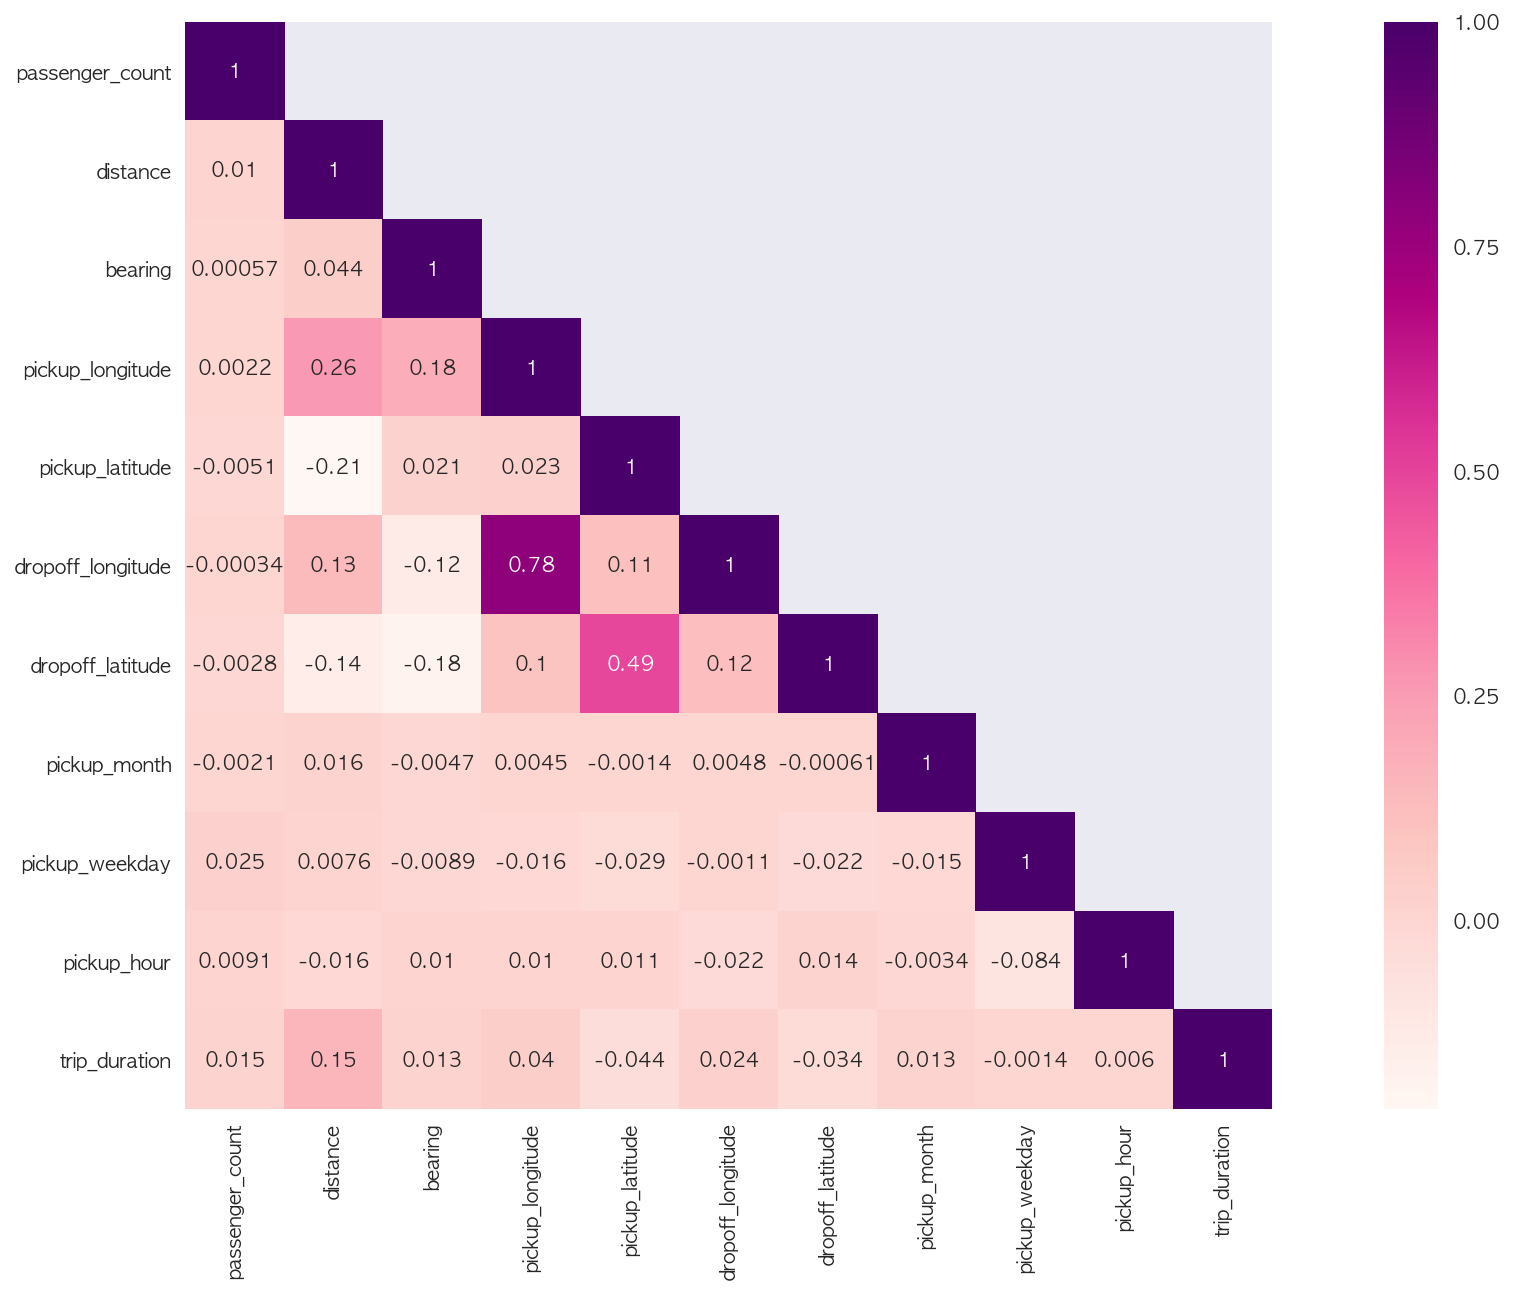

In [36]:
col_reals = col_real + ["pickup_month", "pickup_weekday", "pickup_hour", "trip_duration"]

corr_matt = train[col_reals].corr()
mask = np.array(corr_matt)
mask[np.tril_indices_from(mask)] = False

fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
sns.heatmap(corr_matt, mask=mask, annot=True, square=True, cmap="RdPu")
plt.show()

### 변수간 상관관계 heatmap (trip duration 로그 변환: distance만이 trip duration과 큰 상관관계를 보임)

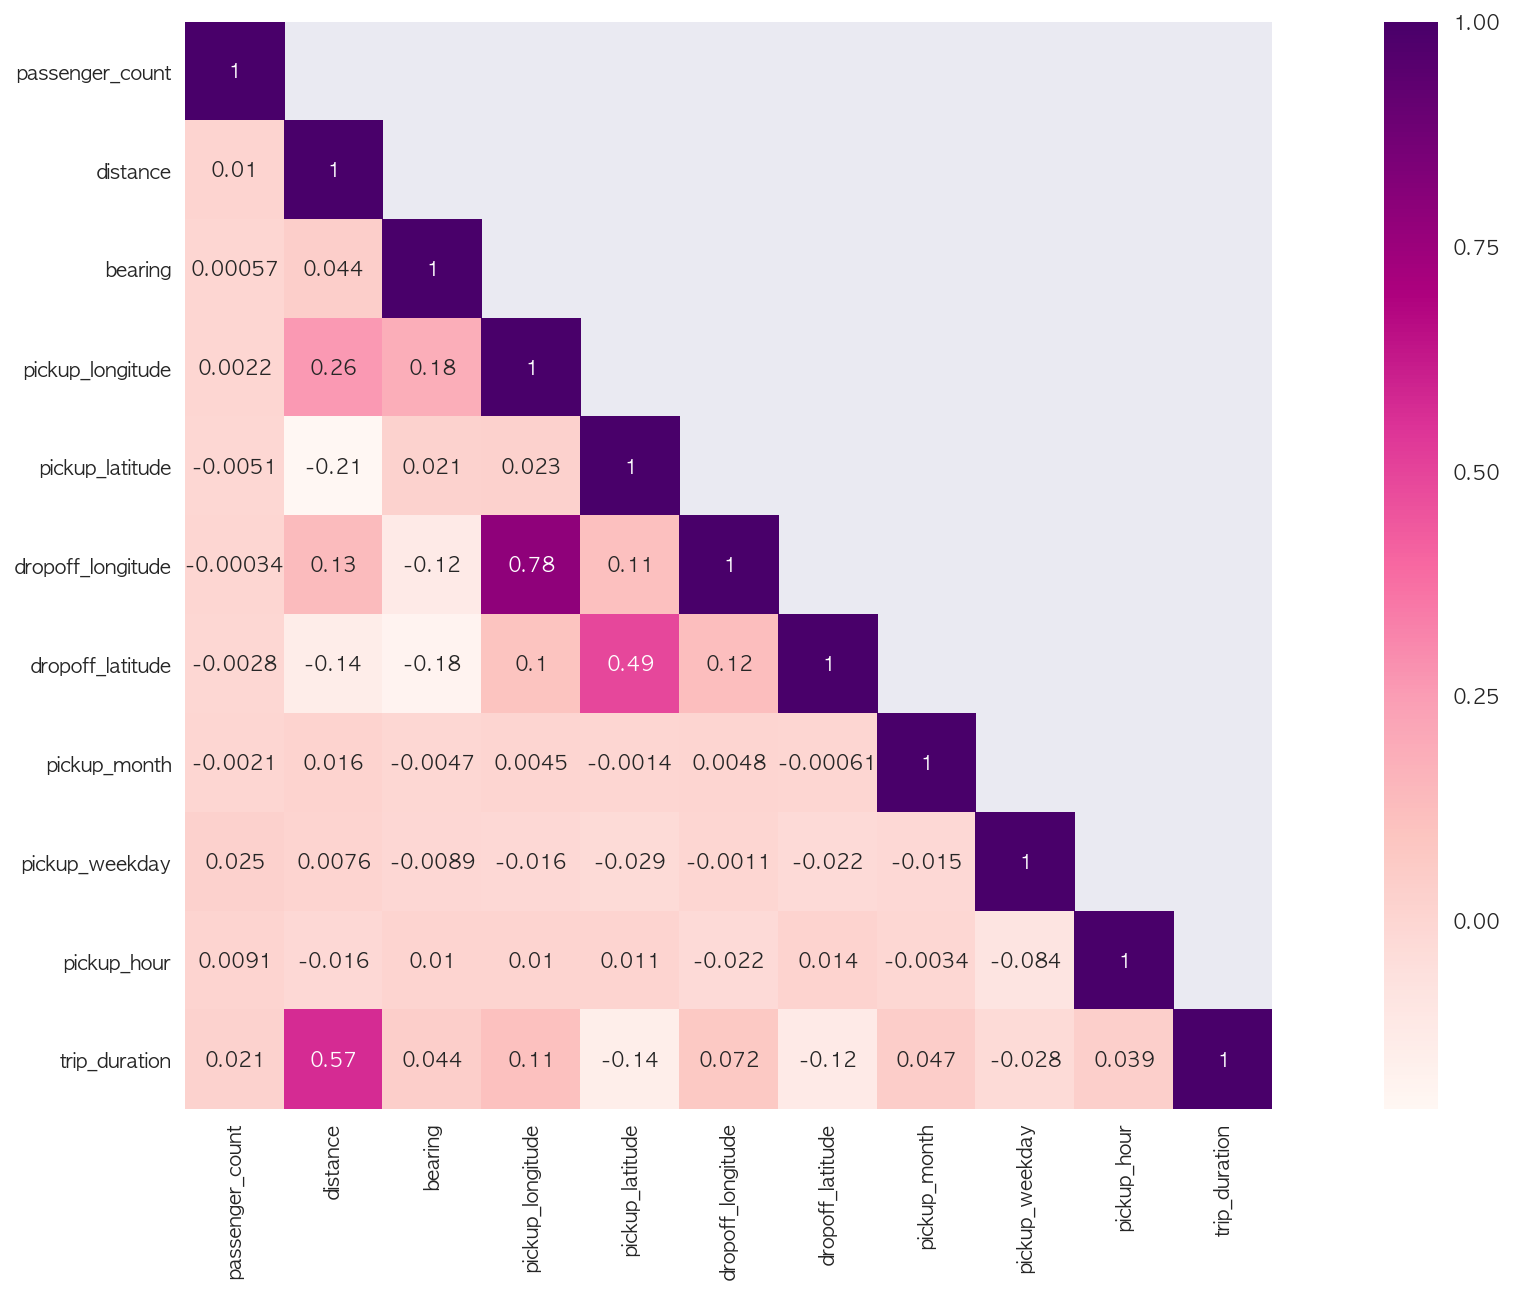

In [37]:
train_log = train[col_reals].copy()
train_log["trip_duration"] = np.log1p(train_log["trip_duration"])

corr_matt_log = train_log.corr()
mask = np.array(corr_matt)
mask[np.tril_indices_from(mask)] = False

fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
sns.heatmap(corr_matt_log, mask=mask, annot=True, square=True, cmap="RdPu")
plt.show()

- 종속변수에 로그를 취할 경우 distance와의 상관관계가 0.5를 넘음

### 2-3. 변수 중요도/영향 파악

### 전체 변수 F-검정

- 모든 변수를 사용한 OLS

In [38]:
model = sm.OLS.from_formula("trip_duration ~ passenger_count + distance + bearing + pickup_month +" 
                            "pickup_weekday + pickup_hour + pickup_latitude + pickup_longitude +"
                            "dropoff_latitude + dropoff_longitude + vendor_id + store_and_fwd_flag"
                            "+ working_day", train)
result = model.fit()

In [39]:
print("R-squared of a model:", result.rsquared)
print("Adjusted R-squared of a model:", result.rsquared_adj)

R-squared of a model: 0.0250067420715
Adjusted R-squared of a model: 0.0249980524469


In [40]:
sm.stats.anova_lm(result, typ=2)

,sum_sq,df,F,PR(>F)
passenger_count,1.783458e+08,1.0,18.187649,2.001854e-05
distance,2.832853e+11,1.0,28889.350234,0.000000e+00
bearing,1.281384e+09,1.0,130.675126,2.925019e-30
pickup_month,1.867088e+09,1.0,190.405067,2.610001e-43
pickup_weekday,9.550070e+08,1.0,97.391338,5.698883e-23
pickup_hour,9.399008e+08,1.0,95.850804,1.240750e-22
pickup_latitude,1.549360e+09,1.0,158.003282,3.103169e-36
pickup_longitude,9.922646e+08,1.0,101.190849,8.368396e-24
dropoff_latitude,3.850458e+08,1.0,39.266853,3.697664e-10
dropoff_longitude,1.773337e+09,1.0,180.844437,3.187930e-41


#### [결과]
- $R^2$와 $Adj. R^2$ 모두 매우 낮음
- 모든 변수들의 p-value가 0에 가까움

### 다중공선성 확인 - VIF (위치변수의 VIF 높음)
- 실수 변수에 시간 변수를 포함해 VIF 확인

In [41]:
col_reals = col_real + ["pickup_hour", "pickup_weekday", "pickup_month"]
train_reals = train[col_reals]

In [42]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(train_reals.values, i) for i in range(train_reals.shape[1])]
vif["features"] = train_reals.columns
vif

,VIF Factor,features
0,2.606389e+00,passenger_count
1,1.714432e+00,distance
2,4.411227e+00,bearing
3,3.819283e+06,pickup_longitude
4,1.815546e+06,pickup_latitude
5,3.590577e+06,dropoff_longitude
6,1.596762e+06,dropoff_latitude
7,5.578639e+00,pickup_hour
8,3.468773e+00,pickup_weekday
9,5.379493e+00,pickup_month


**[VIF 결과]**
- **위치 변수들의 VIF가 높게 나옴**

### 카테고리 변수 영향도 파악 (클래스 구별에 따른 그룹간 분산 변화가 없다고 보기 어려움)
- vendor_id
- store_and_fwd_flag
- working_day

In [43]:
model_vd = sm.OLS.from_formula("trip_duration ~ C(vendor_id) + 0", data=train)
sm.stats.anova_lm(model_vd.fit())

,df,sum_sq,mean_sq,F,PR(>F)
C(vendor_id),2.0,1.343028e+12,6.715140e+11,66854.509205,0.0
Residual,1458638.0,1.465116e+13,1.004441e+07,NaN,NaN


In [44]:
model_wd = sm.OLS.from_formula("trip_duration ~ C(working_day) + 0", data=train)
sm.stats.anova_lm(model_wd.fit())

,df,sum_sq,mean_sq,F,PR(>F)
C(working_day),2.0,1.325165e+12,6.625827e+11,65885.002894,0.0
Residual,1458638.0,1.466902e+13,1.005665e+07,NaN,NaN


In [45]:
model_flag = sm.OLS.from_formula("trip_duration ~ C(store_and_fwd_flag) + 0", data=train)
sm.stats.anova_lm(model_flag.fit())

,df,sum_sq,mean_sq,F,PR(>F)
C(store_and_fwd_flag),2.0,1.324369e+12,6.621844e+11,65841.818747,0.0
Residual,1458638.0,1.466982e+13,1.005720e+07,NaN,NaN


### One-Way ANOVA

In [46]:
sp.stats.f_oneway(train[train["working_day"]==0]["trip_duration"], 
                  train[train["working_day"]==1]["trip_duration"])

F_onewayResult(statistic=92.38540001309029, pvalue=7.1445130281704058e-22)

In [47]:
sp.stats.f_oneway(train[train["store_and_fwd_flag"]==0]["trip_duration"], 
                  train[train["store_and_fwd_flag"]==1]["trip_duration"])

F_onewayResult(statistic=13.167956950284623, pvalue=0.00028478677314214095)

In [48]:
sp.stats.f_oneway(train[train["vendor_id"]==1]["trip_duration"], 
                  train[train["vendor_id"]==2]["trip_duration"])

F_onewayResult(statistic=1870.8577293916605, pvalue=0.0)

### 변수 분석 Summary

### 2-1. 변수의 시각화
- trip_duration : 500시간 이상 outlier 4건 확인 및 제거, log 취할 시 정규성 띔.
- 실수변수, 카테고리변수 plotting : 24시간 이상 outlier 1,895건 확인.
- 위치변수 (경,위도) : mapping결과 명백한 outlier발견 (미서부, 캐나다, 대서양 위치).
- 시간변수 (datetime) :
    - pickup_hour : 9~19시 trip_duration 높음.
    - pickup_month : 6월로 갈수록 trip_duration 높음.
    - working_day : 주중(0)이 trip_duration 더 높음.

### 2-2. 변수 간 상관관계 (heatmap)
- 위치변수 (경,위도) : 경도-경도, 위도-위도 간 높은 상관관계.
- trip_duration - distance : log(trip_duration)에 높은 상관관계.

### 2-3. 변수 중요도 / 영향 파악 (경위도 변수를 제외하고 전반적으로  유의미한 영향도 파악은 어려움)
- F검정 :
    - 개별 변수들의 p-value는 전부 0에 가까움
    - 해당 검정으로 유의미한 결과를 얻기는 어려웠음
- VIF : 경,위도 변수간 다중공산성이 높음 -> 일부 경,위도 변수는 모델링 시 제외해야 함
- 카테고리 변수 3개 : 클래스 구별에 따른 그룹간 분산 변화가 없다고 보기 어려움

## 3. Modeling

### 3-1. 1차 Modeling trial & error

- 변수들의 다양한 조합
- speed 변수 사용 시도

<img src=https://github.com/novdov/dss7b5-nyctaxi/blob/master/img/ols_try_01.png?raw=true>
<img src=https://github.com/novdov/dss7b5-nyctaxi/blob/master/img/ols_try_02.png?raw=true>

### 3-2 2차 Modeling

- Outlier 수동 제거
    - 시작 전 데이터의 경향으로부터 너무 벗어났다고 판단된 outlier 제거 (입력 오류로 보이는 데이터)
    - trip_duration 80000 (22시간) 이상
    - 뉴욕 경계를 매우 벗어난 위치 데이터


- 변수 선택
    - VIF가 높은 위치 데이터 중 pickup_longitude만 선택
    - 실수 변수: distance, bearing, pickup_month, pickup_weekday, pickup_hour, pickup_longitude
    - 카테고리 변수: vendor_id


- 변수 변환
    - 모든 변수 scaling
    - trip_duration과 distance log변환
    - pickup_hour, pickup_weekday 다항회귀

In [49]:
train = train[train["trip_duration"] < 80000]

In [50]:
train = train[train["pickup_latitude"] < 45]
train = train[train["pickup_longitude"] > -100]
train = train[train["dropoff_latitude"] > 36]
train = train[train["dropoff_latitude"] > -120]

### 2차 Modeling 1

In [51]:
model = sm.OLS.from_formula("scale(np.log1p(trip_duration)) ~ scale(np.log1p(distance)) + scale(bearing)"
                            "+ scale(pickup_month) + scale(pickup_weekday) + scale(pickup_hour)"
                            "+ scale(pickup_longitude) + scale(dropoff_longitude) + C(vendor_id)", train)
result_01 = model.fit()
print(result_01.summary())

                                  OLS Regression Results                                  
Dep. Variable:     scale(np.log1p(trip_duration))   R-squared:                       0.612
Model:                                        OLS   Adj. R-squared:                  0.612
Method:                             Least Squares   F-statistic:                 2.868e+05
Date:                            Thu, 15 Mar 2018   Prob (F-statistic):               0.00
Time:                                    14:34:31   Log-Likelihood:            -1.3781e+06
No. Observations:                         1456739   AIC:                         2.756e+06
Df Residuals:                             1456730   BIC:                         2.756e+06
Df Model:                                       8                                         
Covariance Type:                        nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.9

### [2차 Modeling 1 결과 진단]

### 잔차 정규성 검토

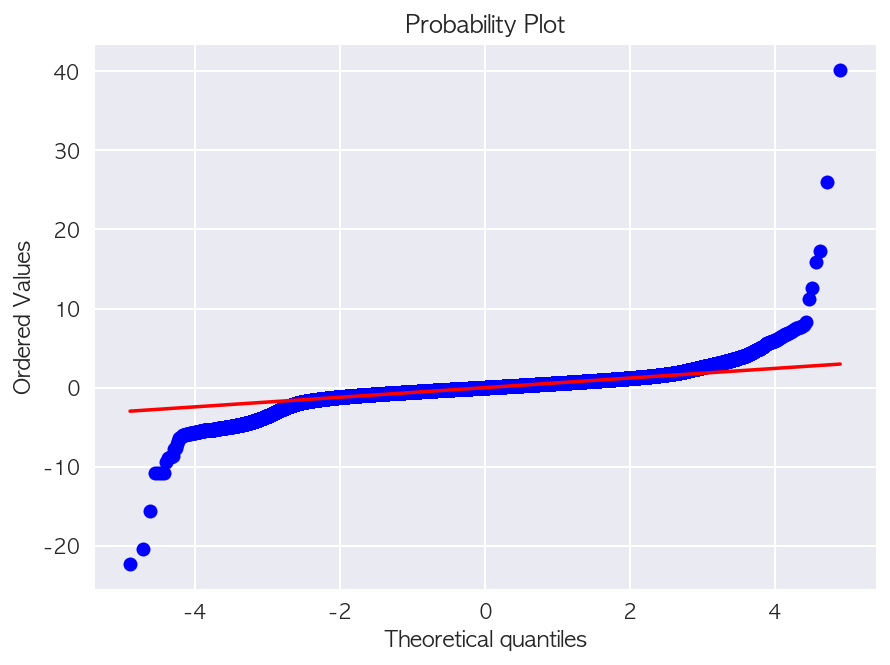

Chi^2       : 385455.765
P-value     :  0.000


In [52]:
plt.figure(figsize=(7, 5))
sp.stats.probplot(result_01.resid, plot=plt)
plt.show()
norm_test = sms.omni_normtest(result_01.resid)
for xi in zip(['Chi^2', 'P-value'], norm_test):
    print("%-12s: %6.3f" % xi)

### 아웃라이어 제거
- Cook's Distance
- Fox' Outlier Recommendation

In [53]:
influence = result_01.get_influence()
cooks_d2, pvals = influence.cooks_distance
fox_cr = 4 / (len(train) - 9)

idx_cooks = np.where(cooks_d2 > fox_cr)[0]
len(idx_cooks)

57687

In [54]:
train_rev01 = train.copy().reset_index(drop=True)

In [55]:
train_rev01.drop(idx_cooks, inplace=True)
train_rev01.reset_index(drop=True, inplace=True)
len(train_rev01), len(train)

(1399052, 1456739)

### 2차 Modeling 2

In [56]:
model = sm.OLS.from_formula("np.log1p(trip_duration) ~ scale(np.log1p(distance)) + scale(bearing)"
                            "+ scale(pickup_month) + scale(pickup_weekday) + scale(I(pickup_weekday**2))"
                            "+ scale(I(pickup_hour**2)) + scale(I(pickup_hour**4))"
                            "+ scale(pickup_longitude) + C(vendor_id)", train_rev01)
result_02 = model.fit()
print(result_02.summary())

                               OLS Regression Results                              
Dep. Variable:     np.log1p(trip_duration)   R-squared:                       0.700
Model:                                 OLS   Adj. R-squared:                  0.700
Method:                      Least Squares   F-statistic:                 3.634e+05
Date:                     Thu, 15 Mar 2018   Prob (F-statistic):               0.00
Time:                             14:36:00   Log-Likelihood:            -6.3620e+05
No. Observations:                  1399052   AIC:                         1.272e+06
Df Residuals:                      1399042   BIC:                         1.273e+06
Df Model:                                9                                         
Covariance Type:                 nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------

### [2차 Modeling 2 결과 진단] - 최종 모델로 선택

### 아웃라이어 제거 후 잔차 정규성 검토

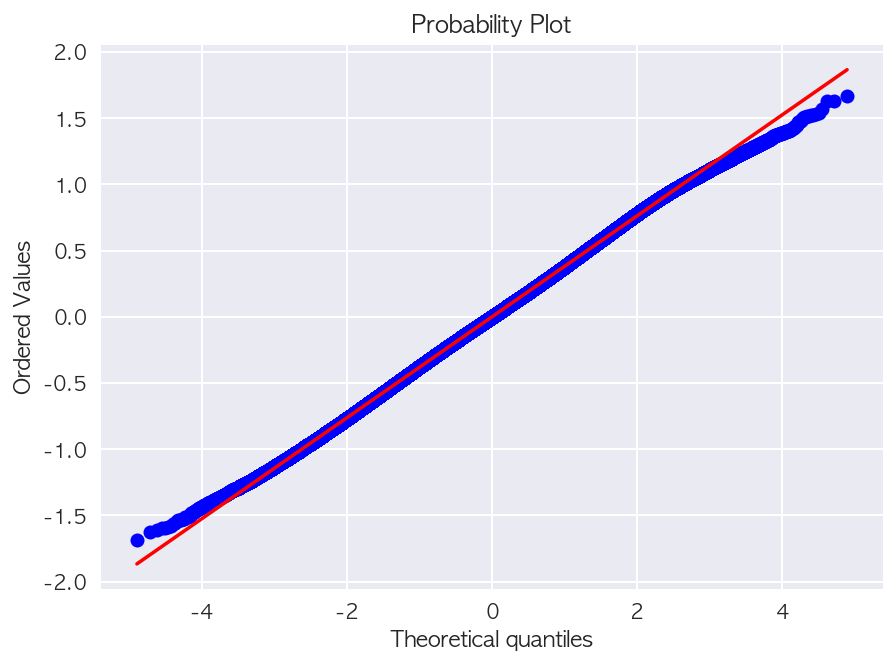

Chi^2       : 13.551
P-value     :  0.001


In [57]:
plt.figure(figsize=(7, 5))
sp.stats.probplot(result_02.resid, plot=plt)
plt.show()
norm_test = sms.omni_normtest(result_02.resid)
for xi in zip(['Chi^2', 'P-value'], norm_test):
    print("%-12s: %6.3f" % xi)

- **해당 모델에서 레버리지, 표준화 잔차, Cook's Distance 등을 통해 데이터 제거 후에도 <font color='red'>유의미한 성능 개선을 보이지 않음</font>**
- 해당 모델을 최종 모델로 선택

### 최종 모델 partial regression plot

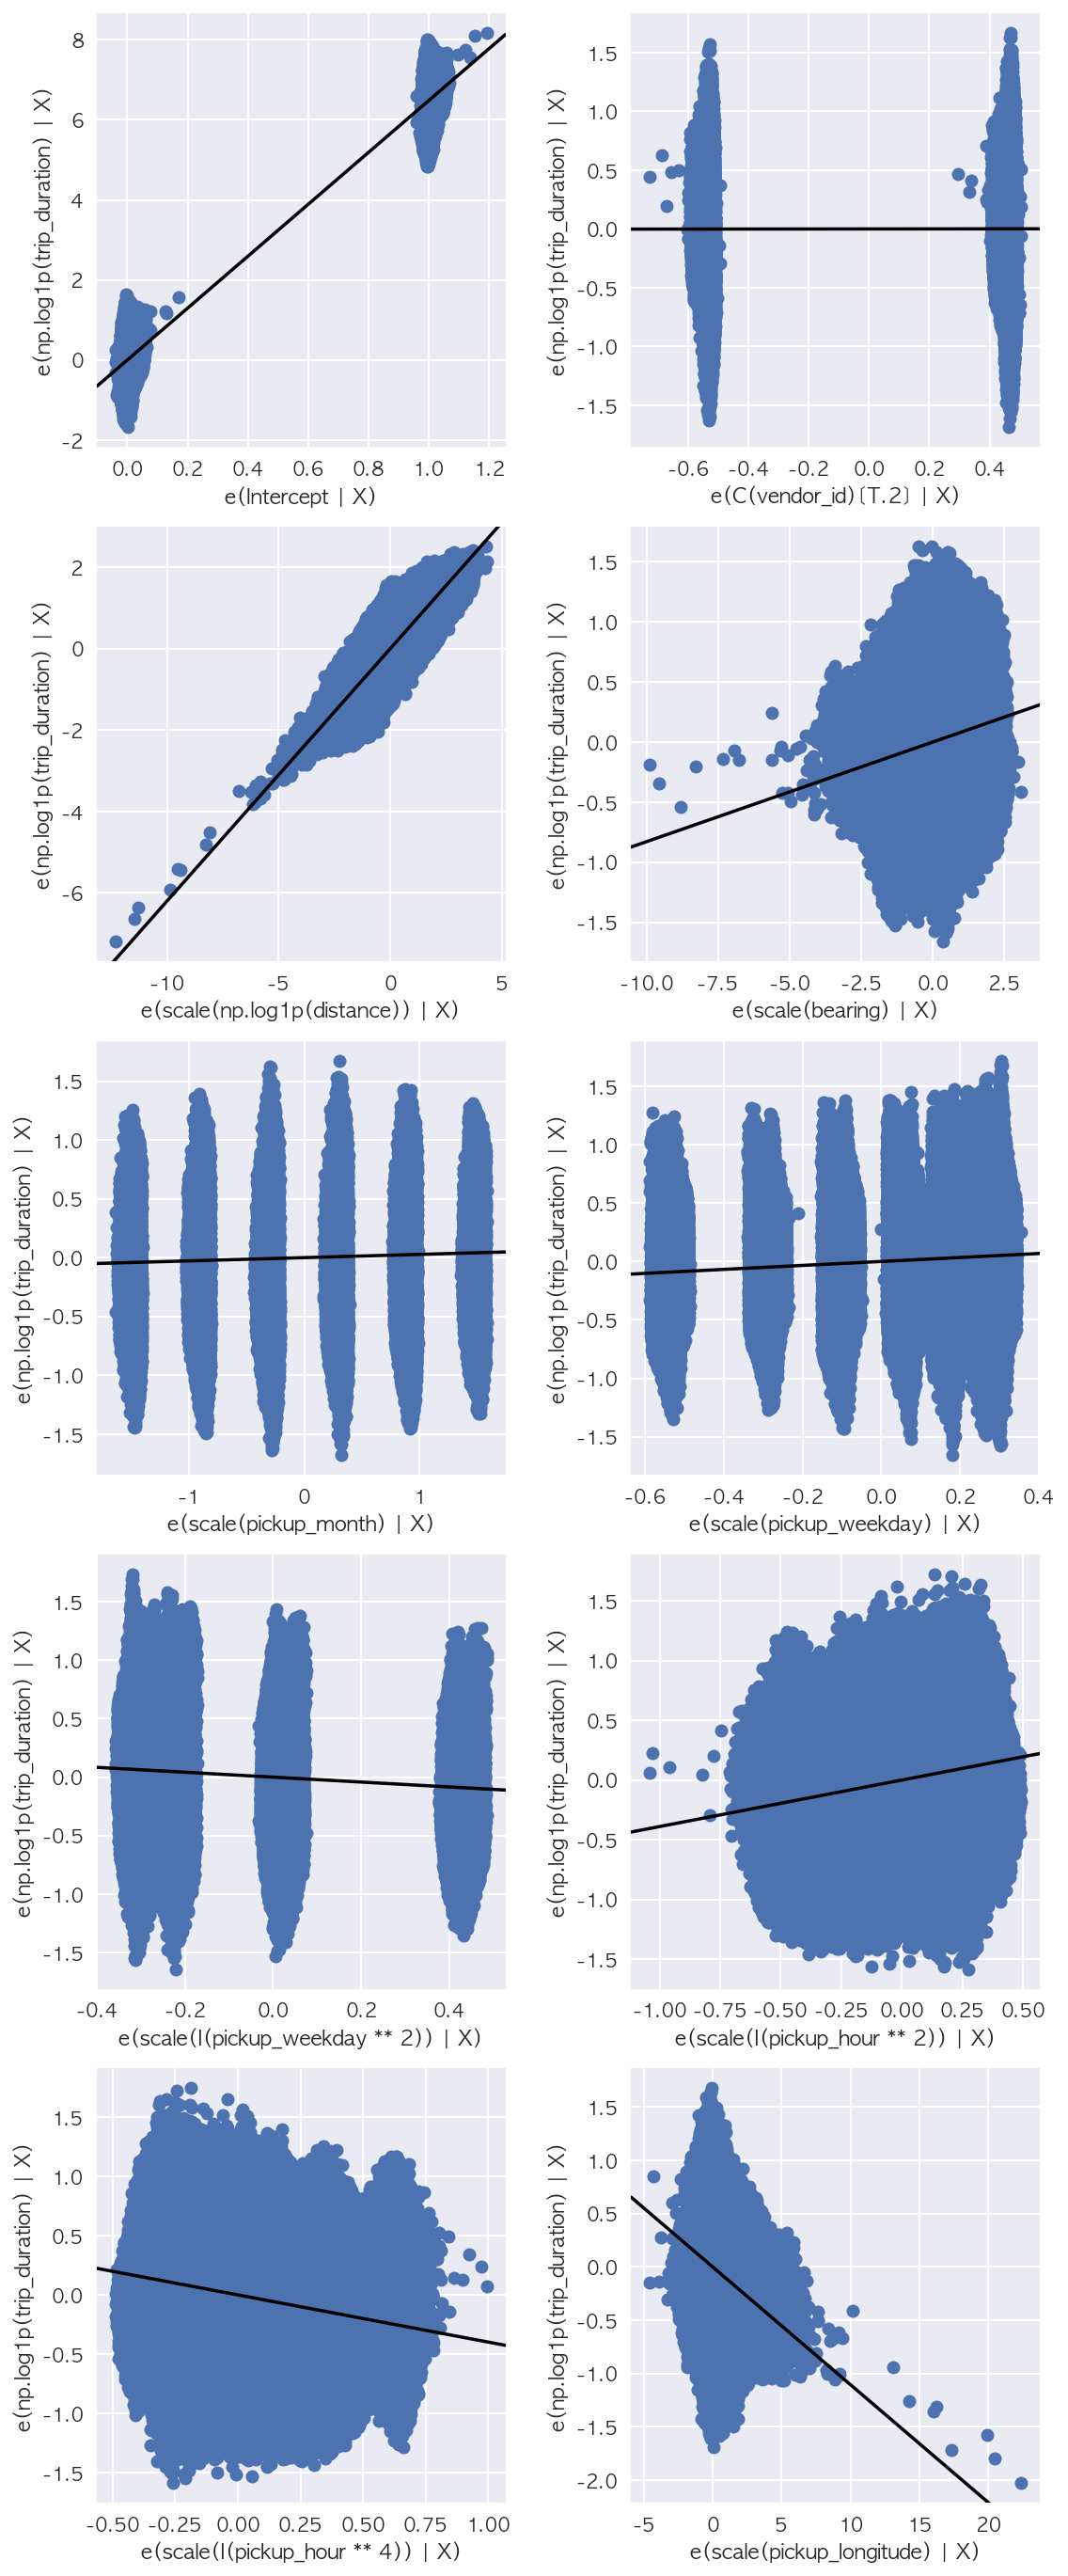

In [58]:
fig = plt.figure(figsize=(8,20))
sm.graphics.plot_partregress_grid(result_02, fig=fig)
fig.suptitle("")
plt.show()

## 4. 결과 진단

In [59]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

In [60]:
y, X = dmatrices("np.log1p(trip_duration) ~ scale(np.log1p(distance)) + scale(bearing)"
                 "+ scale(pickup_month) + scale(pickup_weekday) + scale(I(pickup_weekday**2))"
                 "+ scale(I(pickup_hour**2)) + scale(I(pickup_hour**4))"
                 "+ scale(pickup_longitude) + C(vendor_id)", train_rev01, return_type="dataframe")

In [61]:
model_lr = LinearRegression().fit(X, y)
model_ridge = Ridge().fit(X, y)
model_lasso = Lasso().fit(X, y)
model_en = ElasticNet().fit(X, y)

### 4-1. Cross Validation

### Cross Validation - $R^2$ (Ridge 선택)

In [62]:
cv = KFold(5)

print("[ Original Model ]")
print("Scores: ", cross_val_score(model_lr, X, y, scoring="r2", cv=cv))
print("Mean:", np.mean(cross_val_score(model_lr, X, y, scoring="r2", cv=cv)))
print("-"*90)

print("[ Ridge ]")
print("Scores: ", cross_val_score(model_ridge, X, y, scoring="r2", cv=cv))
print("Mean:", np.mean(cross_val_score(model_ridge, X, y, scoring="r2", cv=cv)))
print("-"*90)

print("[ Lasso ]")
print("Scores: ", cross_val_score(model_lasso, X, y, scoring="r2", cv=cv))
print("Mean:", np.mean(cross_val_score(model_lasso, X, y, scoring="r2", cv=cv)))
print("-"*90)

print("[ Elastic Net ]")
print("Scores: ", cross_val_score(model_en, X, y, scoring="r2", cv=cv))
print("Mean:", np.mean(cross_val_score(model_en, X, y, scoring="r2", cv=cv)))

[ Original Model ]
Scores:  [ 0.69916994  0.69921489  0.70080439  0.70117302  0.70166889]
Mean: 0.700406224669
------------------------------------------------------------------------------------------
[ Ridge ]
Scores:  [ 0.69916994  0.69921489  0.7008044   0.70117301  0.70166888]
Mean: 0.700406224698
------------------------------------------------------------------------------------------
[ Lasso ]
Scores:  [ -1.20405227e-06  -9.43776473e-07  -1.17362004e-06  -7.73427859e-07
  -4.36783204e-06]
Mean: -1.69254173725e-06
------------------------------------------------------------------------------------------
[ Elastic Net ]
Scores:  [ 0.08961726  0.08966655  0.08921951  0.08899903  0.08919197]
Mean: 0.0893388621552


### Cross Validation - RMSLE score

In [63]:
from sklearn.metrics import make_scorer

def rmsle(predicted_values, actual_values):
    predicted_values = np.array(predicted_values)
    actual_values = np.array(actual_values)
    
    log_predict = np.log(predicted_values + 1)
    log_actual = np.log(actual_values + 1)
    
    difference = log_predict - log_actual
    difference = np.square(difference)
    
    mean_difference = difference.mean()
    
    score = np.sqrt(mean_difference)
    
    return score

rmsle_scorer = make_scorer(rmsle)

In [64]:
cv = KFold(5)

print("[ Original Model ]")
print("Scores: ", cross_val_score(model_lr, X, y, scoring=rmsle_scorer, cv=cv))
print("Mean:", np.mean(cross_val_score(model_lr, X, y, scoring=rmsle_scorer, cv=cv)))
print("-"*90)

print("[ Ridge ]")
print("Scores: ", cross_val_score(model_ridge, X, y, scoring=rmsle_scorer, cv=cv))
print("Mean:", np.mean(cross_val_score(model_ridge, X, y, scoring=rmsle_scorer, cv=cv)))

[ Original Model ]
Scores:  [ 0.05257187  0.05253089  0.05242587  0.05247082  0.05234433]
Mean: 0.0524687565897
------------------------------------------------------------------------------------------
[ Ridge ]
Scores:  [ 0.05257187  0.05253089  0.05242588  0.05247082  0.05234434]
Mean: 0.052468759013


### 4-2. 정규화 하이퍼모수 최적화 (alpha=0.79에서 최대 성능)

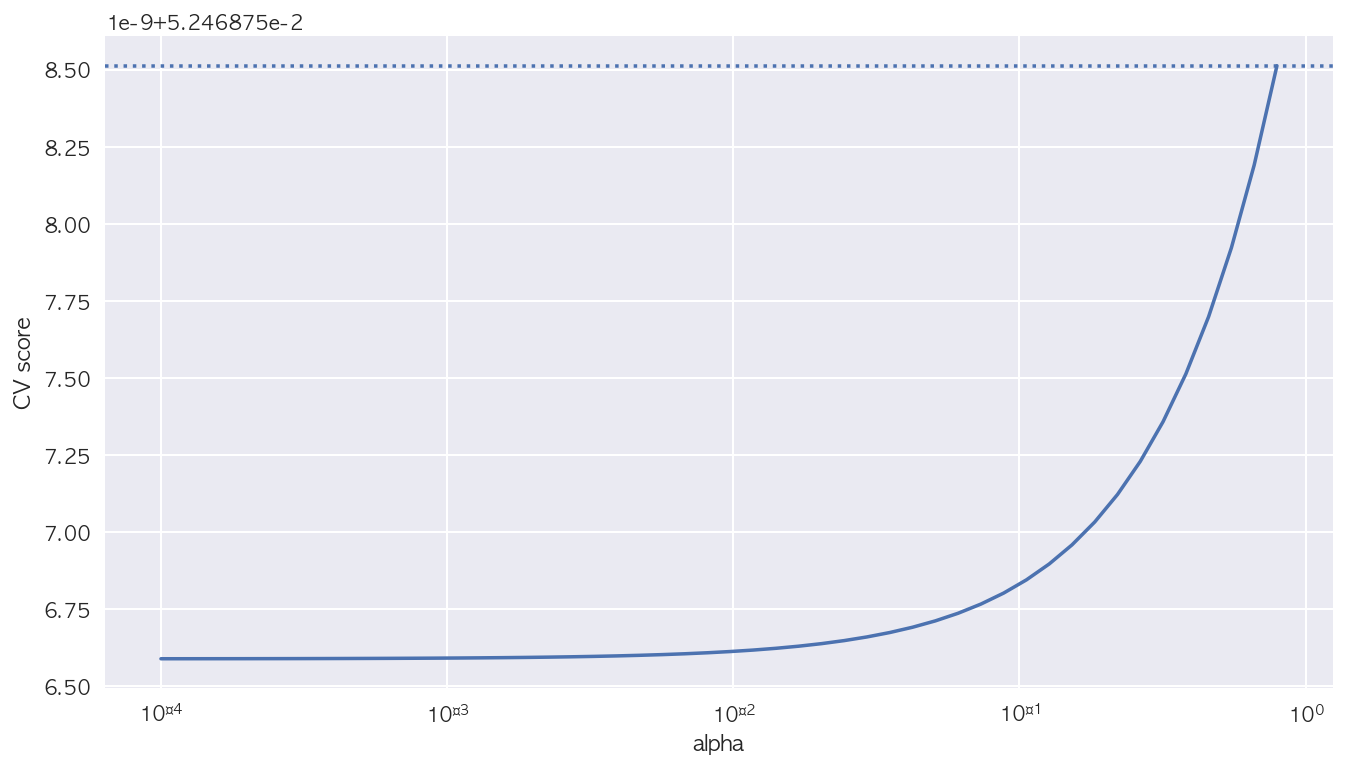

0.794328234724


In [65]:
from sklearn.linear_model import RidgeCV

alphas = np.logspace(-4, -.1, 50)
ridge_cv = RidgeCV(alphas=alphas, cv=5).fit(X, y)
scores = list()

for alpha in alphas:
    model_ridge.alpha = alpha
    this_scores = cross_val_score(model_ridge, X, y, scoring=rmsle_scorer, cv=5)
    scores.append(np.mean(this_scores))

plt.figure(figsize=(11, 6))
plt.semilogx(alphas, scores)
plt.ylabel('CV score')
plt.xlabel('alpha')
plt.axhline(np.max(scores), linestyle=':')
plt.show()
print(ridge_cv.alpha_)

### 하이퍼모수 최적화 후 최종 모델을 통해 예측값 도출

### 하이퍼모수 최적화 후 최종모델

<font color = 'Black', size = 4> $\log(y)$ =<br> $+$ $0.00200266(VendorId)$ <br> $+$ $0.61990152(\log(distance))$ <br>$+$ $0.08296207(bearing)$ <br>$+$ $0.02759854(PickupMonth)$ <br>$+$ $0.16996618(PickupWeekday)$<br>$-$  $0.20961198(PickupWeekday^2)$<br>$+$ $0.38922529(PickupHour^2)$<br>$-$ $0.39766588(PickupHour^4)$<br>$-$ $0.11056248(PickupLongitude)$

In [66]:
test["pickup_month"] = test["pickup_datetime"].dt.month
test["pickup_weekday"] = test["pickup_datetime"].dt.weekday
test["pickup_hour"] = test["pickup_datetime"].dt.hour
lat1, lng1, lat2, lng2 = (test['pickup_latitude'].values, test['pickup_longitude'].values, 
                          test['dropoff_latitude'].values, test['dropoff_longitude'].values)
test = test.assign(distance = haversine_array(lat1, lng1, lat2, lng2))
test = test.assign(bearing = bearing_array(lat1, lng1, lat2, lng2))

In [67]:
X_test = dmatrix("scale(np.log1p(distance)) + scale(bearing)"
                 "+ scale(pickup_month) + scale(pickup_weekday) + scale(I(pickup_weekday**2))"
                 "+ scale(I(pickup_hour**2)) + scale(I(pickup_hour**4))"
                 "+ scale(pickup_longitude) + C(vendor_id)", test, return_type="dataframe")

In [68]:
pred = ridge_cv.predict(X_test)

In [70]:
import datetime
now = datetime.datetime.now()
submission_kaggle = pd.read_csv("sample_submission.csv")
submission_kaggle["trip_duration"] = np.expm1(pred)
submission_kaggle.to_csv("../submission_{month}{day}.csv".format(month=now.month, day=now.day), index=False)

## 5. Kaggle Submission (Score: 0.50591, 808/1257)

<img src=https://github.com/novdov/dss7b5-nyctaxi/blob/master/img/rkaggle_submission_0314_02.png?raw=true>

In [71]:
print("Approximate ranking: ", "상위 {:.2f}%".format(808/1257 * 100))

Approximate ranking:  상위 64.28%


## 6. Lesson

### 아쉬운 점

- feature 개수가 적은 상황에서 주어진 feature의 제한적인 활용으로 모델 성능 개선이 어려웠음
    - 위/경도 변수로부터 ‘distance’만 유의미하게 활용함
    - speed 활용한 모델링 실패 (아웃라이어 제거할수록 잔차 정규성 악화)
    - 시간별 trip duration의 유의미한 변화를 발견했지만 모델에 적극적으로 반영되지 못함
        - 각 시간 변수의 interaction이 반영되지 않음
        - 실수변수로 반영했지만, polynomial 특성을 제대로 파악/반영하지 못함
    - 한 번에 전체 데이터를 학습시켜 시간이 걸리는 문제 (batch 등의 활용 아쉬움)
        
- OLS분석 진행시 과학적인 모델링 방법론의 부재에 대한 아쉬움